In [1]:
%tensorflow_version 1.x
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import warnings
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D,Convolution2D,AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers.merge import concatenate
from keras.models import Model
from keras import regularizers
from keras import initializers
from keras import backend as K
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 10
default_image_size = tuple((299, 299))
image_size = 0
directory_root = "/content/drive/My Drive/Tugas3 Deep Learning/"
width=299
height=299
depth=3

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".jpeg") == True or image_directory.endswith(".png") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    %time print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing covid ...
[INFO] Processing normal ...
Error : [Errno 20] Not a directory: '/content/drive/My Drive/Tugas3 Deep Learning//label_transform.pkl'


In [5]:
image_size = len(image_list)
image_size

148

In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [7]:
print(label_binarizer.classes_)

['covid' 'normal']


In [0]:
label = []
for i in image_labels:
    if i == [0]:
       label.append([1,0])
    else:
       label.append([0,1])
       
labels = np.array(label)

In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [10]:

print("[INFO] Spliting data to train, test, and validate")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test, and validate


In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [12]:
'''
Copyright 2017 TensorFlow Authors and Kent Sommer

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
'''
WEIGHTS_PATH = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5'
def preprocess_input(x):
    x = np.divide(x, 255.0)
    x = np.subtract(x, 0.5)
    x = np.multiply(x, 2.0)
    return x
def conv2d_bn(x, nb_filter, num_row, num_col,
              padding='same', strides=(1, 1), use_bias=False):
    """
    Utility function to apply conv + BN. 
    (Slightly modified from https://github.com/fchollet/keras/blob/master/keras/applications/inception_v3.py)
    """
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    x = Convolution2D(nb_filter, (num_row, num_col),
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias,
                      kernel_regularizer=regularizers.l2(0.00004),
                      kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(x)
    x = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(x)
    x = Activation('relu')(x)
    return x

def block_inception_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 96, 1, 1)
    branch_1 = conv2d_bn(input, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3)
    branch_2 = conv2d_bn(input, 64, 1, 1)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)
    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 96, 1, 1)
    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x

def block_reduction_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    branch_0 = conv2d_bn(input, 384, 3, 3, strides=(2,2), padding='valid')
    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 3, 3)
    branch_1 = conv2d_bn(branch_1, 256, 3, 3, strides=(2,2), padding='valid')
    branch_2 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(input)
    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x
def block_inception_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    branch_0 = conv2d_bn(input, 384, 1, 1)
    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 1, 7)
    branch_1 = conv2d_bn(branch_1, 256, 7, 1)
    branch_2 = conv2d_bn(input, 192, 1, 1)
    branch_2 = conv2d_bn(branch_2, 192, 7, 1)
    branch_2 = conv2d_bn(branch_2, 224, 1, 7)
    branch_2 = conv2d_bn(branch_2, 224, 7, 1)
    branch_2 = conv2d_bn(branch_2, 256, 1, 7)
    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 128, 1, 1)
    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x

def block_reduction_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    branch_0 = conv2d_bn(input, 192, 1, 1)
    branch_0 = conv2d_bn(branch_0, 192, 3, 3, strides=(2, 2), padding='valid')
    branch_1 = conv2d_bn(input, 256, 1, 1)
    branch_1 = conv2d_bn(branch_1, 256, 1, 7)
    branch_1 = conv2d_bn(branch_1, 320, 7, 1)
    branch_1 = conv2d_bn(branch_1, 320, 3, 3, strides=(2,2), padding='valid')
    branch_2 = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(input)
    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x
def block_inception_c(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    branch_0 = conv2d_bn(input, 256, 1, 1)
    branch_1 = conv2d_bn(input, 384, 1, 1)
    branch_10 = conv2d_bn(branch_1, 256, 1, 3)
    branch_11 = conv2d_bn(branch_1, 256, 3, 1)
    branch_1 = concatenate([branch_10, branch_11], axis=channel_axis)
    branch_2 = conv2d_bn(input, 384, 1, 1)
    branch_2 = conv2d_bn(branch_2, 448, 3, 1)
    branch_2 = conv2d_bn(branch_2, 512, 1, 3)
    branch_20 = conv2d_bn(branch_2, 256, 1, 3)
    branch_21 = conv2d_bn(branch_2, 256, 3, 1)
    branch_2 = concatenate([branch_20, branch_21], axis=channel_axis)
    branch_3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 256, 1, 1)
    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x
def inception_v4_base(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    # Input Shape is 299 x 299 x 3 (th) or 3 x 299 x 299 (th)
    #Stem Block
    net = conv2d_bn(input, 32, 3, 3, strides=(2,2), padding='valid')
    net = conv2d_bn(net, 32, 3, 3, padding='valid')
    net = conv2d_bn(net, 64, 3, 3)
    branch_0 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)
    branch_1 = conv2d_bn(net, 96, 3, 3, strides=(2,2), padding='valid')
    net = concatenate([branch_0, branch_1], axis=channel_axis)
    branch_0 = conv2d_bn(net, 64, 1, 1)
    branch_0 = conv2d_bn(branch_0, 96, 3, 3, padding='valid')
    branch_1 = conv2d_bn(net, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 64, 1, 7)
    branch_1 = conv2d_bn(branch_1, 64, 7, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3, padding='valid')
    net = concatenate([branch_0, branch_1], axis=channel_axis)
    branch_0 = conv2d_bn(net, 192, 3, 3, strides=(2,2), padding='valid')
    branch_1 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)
    net = concatenate([branch_0, branch_1], axis=channel_axis)
    # 35 x 35 x 384
    # 4 x Inception-A blocks
    for idx in range(4):
    	net = block_inception_a(net)
    # 35 x 35 x 384
    # Reduction-A block
    net = block_reduction_a(net)
    # 17 x 17 x 1024
    # 7 x Inception-B blocks
    for idx in range(7):
    	net = block_inception_b(net)
    # 17 x 17 x 1024
    # Reduction-B block
    net = block_reduction_b(net)
    # 8 x 8 x 1536
    # 3 x Inception-C blocks
    for idx in range(3):
    	net = block_inception_c(net)
    return net
def inception_v4(num_classes, dropout_keep_prob, weights, include_top):
    '''
    Creates the inception v4 network

    Args:
    	num_classes: number of classes
    	dropout_keep_prob: float, the fraction to keep before final layer.
    
    Returns: 
    	logits: the logits outputs of the model.
    '''
    # Input Shape is 299 x 299 x 3 (tf) or 3 x 299 x 299 (th)
    if K.image_data_format() == 'channels_first':
        inputs = Input((3, 299, 299))
    else:
        inputs = Input((299, 299, 3))
    # Make inception base
    x = inception_v4_base(inputs)
    # Final pooling and prediction
    if include_top:
        # 1 x 1 x 1536
        x = AveragePooling2D((8,8), padding='valid')(x)
        x = Dropout(dropout_keep_prob)(x)
        x = Flatten()(x)
        # 1536
        x = Dense(units=num_classes, activation='softmax')(x)
    model = Model(inputs, x, name='inception_v4')
    # load weights
    if weights == 'imagenet':
        if K.image_data_format() == 'channels_first':
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
        if include_top:
            weights_path = get_file(
                'inception-v4_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='9fe79d77f793fe874470d84ca6ba4a3b')
        else:
            weights_path = get_file(
                'inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='9296b46b5971573064d12e4669110969')
        model.load_weights(weights_path, by_name=True)
    return model


def create_model(num_classes=1001, dropout_prob=0.2, weights=None, include_top=False):
    return inception_v4(num_classes, dropout_prob, weights, include_top)
# ----------------------------------------------------------
incept_model = create_model(num_classes=1001, dropout_prob=0.2, weights=None, include_top=False)
incept_model.load_weights('/content/drive/My Drive/Deep Learning/input/inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5')
for l in incept_model.layers: 
    if l is not None: l.trainable = True 
        
x = incept_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = BatchNormalization()(x)
#x = Dense(1024, activation='relu')(x)
#x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
#x = Dropout(0.2)(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=incept_model.input, outputs=predictions)        


Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [13]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
#Configure the Model for training
model.compile(Adam(lr=0.0001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
#Training the Model
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=100, 
    verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
11/11 [==============================] - 36s 3s/step - loss: 1.2647 - accuracy: 0.7593 - val_loss: 2.5822 - val_accuracy: 0.4667
Epoch 2/100
11/11 [==============================] - 4s 349ms/step - loss: 0.8381 - accuracy: 0.9630 - val_loss: 3.1563 - val_accuracy: 0.4667
Epoch 3/100
11/11 [==============================] - 4s 362ms/step - loss: 0.8214 - accuracy: 0.9907 - val_loss: 3.4539 - val_accuracy: 0.4667
Epoch 4/100
11/11 [==============================] - 4s 359ms/step - loss: 0.8590 - accuracy: 0.9444 - val_loss: 3.1216 - val_accuracy: 0.4667
Epoch 5/100
11/11 [==============================] - 4s 352ms/step - loss: 0.8282 - accuracy: 0.9818 - val_loss: 2.9239 - val_accuracy: 0.4667
Epoch 6/100
11/11 [==============================] - 4s 349ms/step - loss: 0.8892 - accuracy: 0.9630 - val_loss: 3.4483 - val_accuracy: 0.4667
Epoch 7/100
11/11 [==============================

In [16]:
#Menampilkan akurasi
score=model.evaluate(x_test,y_test, verbose=True)
print("Test Accuracy : %0.02f %%" % (score [1]*100))

30/30 [==============================] - 1s 29ms/step
Test Accuracy : 56.67 %


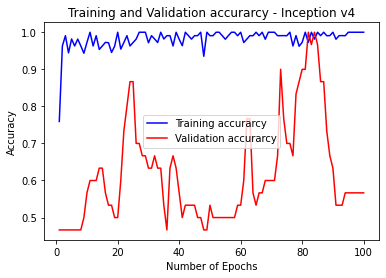

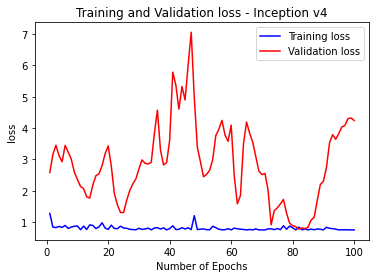

In [17]:
#Visualisasi akurasi dan loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy - Inception v4')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss - Inception v4')
plt.ylabel('loss')
plt.xlabel('Number of Epochs')
plt.legend()
plt.show()